# DISPLAY RESULTS

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np 
  

In [53]:
def retrieve_df_data_from_folder_path(folder_path,model_name, nav_type, load_model=False):
    df_list = []
    filepath_list = []
    i=0
    
    for dirpath, dirnames, filenames in os.walk(folder_path):
        #print(model_name+'.pkl' in dirpath.split('/')[-1], dirpath.split('/')[-1], model_name)
        # print('I want : True, True, pkl in modelname ')
        
        if len(dirnames) != 0:  # Skip directories that contain subdirectories
            continue
        elif nav_type == 'goal' and 'cscg' in model_name and not model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        #We want a model as prior
        elif nav_type == 'goal' and 'ours' in model_name and load_model and not model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        #Vanilla model
        elif nav_type == 'goal' and 'ours' in model_name and not load_model and model_name+'.pkl' in dirpath.split('/')[-1]:
            continue
        i+=1
        #print('dirpath', dirpath,i)
        for file in filenames:
            if file.endswith('.xlsx'):
                file_path = os.path.join(dirpath, file)
                try:
                    df = pd.read_excel(file_path)
                    # if df['error'][0] != False or df['error'][0] !=0:
                    #     print('erase',file_path)
                    #     os.system(f'rm -rf {file_path}')
                    # df.fillna(value=0, inplace=True)  # Fill any blank cells with 'NA'
                    df_list.append(df)
                    filepath_list.append(dirpath)
                except pd.errors.ParserError as e:
                    print(f"Skipping file {file_path} due to ParserError: {e}")

    return df_list, filepath_list

In [4]:
#BAR PLOTS AVERAGE_STEPS
def bar_plot(data, group, data_name, group_name, model_names):
    width = 0.7/len(data)
    bar_pose = -0.7/len(data) 

    colors = ['green','orange', 'grey', 'cyan', 'pink', 'blue']
    x = np.arange(len(group)) 
    for id, model in enumerate(data):
        # plot data in grouped manner of bar type 
        plt.bar(x+bar_pose, model, width, color=colors[id]) 
        bar_pose+= 0.7/len(data) 
    plt.xticks(x, group) 
    plt.xlabel(group_name) 
    plt.ylabel(data_name) 
    plt.legend(model_names) 
    plt.savefig('figures/'+ data_name +'_models_per_'+ group_name +'.jpg')
    plt.show() 

## Average Steps

### Agglomerate data

In [5]:
env = 'grid_3x3'
model_name = 'ours_v3'
nav_type = 'goal'
if 'ours' in model_name:
    who = 'ours'
else:
    who = 'cscg'

# Set the path to the folder containing the excel files
if nav_type == 'exploration':
    folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
else:
    folder_path = 'results/'+ env +'/' + who+'_'+ nav_type

print(folder_path)

df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
combined_df = pd.concat(df_list)
# print(len(df_list))
# # Write the combined DataFrame to a new excel file
combined_df.to_excel('results/' + env+'_'+model_name+'_'+ nav_type +'_combined.xlsx', index=False)


results/grid_3x3/ours_goal
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4/ours_v3_goal_ob:4_2024-01-29-14-47-03 1
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4/ours_v3_goal_ob:4_2024-01-29-13-26-39 2
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-07-16-15-50 3
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-07-16-06-02 4
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:3_2024-02-08-13-17-19 5
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:3_2024-02-07-16-32-23 6
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:11_2024-02-08-13-16-03 7
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-07-15-52-05 8
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-08-13-15-54 9
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-07-15-48-48 10
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:4_2024-02-08-13-18-38 11
dirpath results/grid_3x3/ours_goal/ours_v3_goal_ob:3_2024-02-08-13-15-58 12
dirpath results/grid_3x3/ours_goa

### exploration

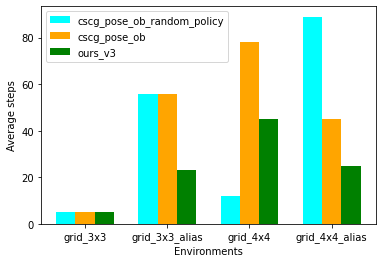

In [6]:
#TEST BAR PLOT

# create data 

envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias']
model_names = ['cscg_pose_ob_random_policy', 'cscg_pose_ob', 'ours_v3', ]

model1 = [5, 56, 12, 89] 
model2 = [5, 56, 78, 45] 
model3 = [5, 23, 45, 25] 

av_steps = [model1]
av_steps.append(model2)
av_steps.append(model3)
width = 0.7/len(av_steps)

bar_pose = -0.7/len(av_steps) 

colors = ['cyan','orange', 'green']
x = np.arange(len(envs)) 
for id, model in enumerate(av_steps):
    # plot data in grouped manner of bar type 
    plt.bar(x+bar_pose, model, width, color=colors[id]) 
    bar_pose+= 0.7/len(av_steps) 
    # plt.bar(x, model2, width, color=) 
    # plt.bar(x+0.2, model3, width, color=) 
plt.xticks(x, envs) 
plt.xlabel("Environments") 
plt.ylabel("Average steps") 
plt.legend(model_names) 
plt.show() 


In [7]:
#GET AVERAGE STEPS PERFECT TRANSITION PER MODEL AND ENVS
envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias']
model_names = ['ours_v3','cscg_pose_ob_random_policy', 'cscg_pose_ob']
nav_type = 'exploration'

average_steps = [[0]*(len(envs)) for _ in range(len(model_names)+1)]
for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
        a_failure = 0
        # i = 0
        average_steps_model = []
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
        print('model', model_name, 'env', env,'number of tests:', len(df_list))
        for df in df_list:
            headers = list(df.columns.values)
            stop_condition_header = [s for s in headers if 'stop_condition_' in s][0]
            # i+=1
            if df[stop_condition_header][0] == True:
                average_steps_model.append(len(df['steps'])-1)
            else:
                a_failure+=1
                # print('failure ', i)
        print('there is ', a_failure, ' failures in this model/env exploration')
        average_steps[id_m][id_e] = np.mean(average_steps_model)
        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        #THIS ASSUMES WE HAVE SQUARED ENVS
        dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
        average_steps[-1][id_e] =  int(dim_env[-1]) * 4 -1
model_names.append('oracle')
print(average_steps)

dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-15-46-25 1
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-16-05-41 2
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-15-56-25 3
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-10-55-17 4
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-08-10-49-27 5
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-11-02-53 6
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-15-51-39 7
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-08-11-14-01 8
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-10-21-12-33 9
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-11-01-40 10
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-07-16-15-28 11
dirpath results/grid_3x3/ours_exploration/ours_v3/ours_v3_2024-02-08-13-14-49 12
dirpath results/grid_3x3/ours_explora

KeyboardInterrupt: 

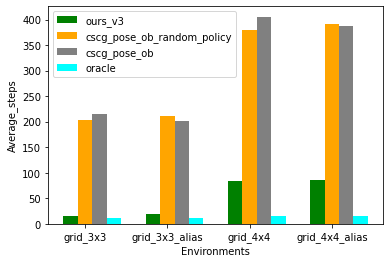

In [ ]:
#BAR PLOTS AVERAGE_STEPS
bar_plot(average_steps, envs, 'Average_steps', 'Environments', model_names)

In [ ]:
#GET AVERAGE STEPS DISCOVERED ALL STATES PER MODEL AND ENVS
envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias']
model_names = ['cscg_pose_ob_random_policy', 'cscg_pose_ob','ours_v3']
nav_type = 'exploration'

average_steps = [[0]*(len(envs)) for _ in range(len(model_names)+1)]
for id_m, model_name in enumerate(model_names):
    for id_e, env in enumerate(envs):
 
        #Get n_rooms
        dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
        width_dim_env = int(dim_env[-1])
        height_dim_env = int(dim_env[0])
        n_rooms = width_dim_env* height_dim_env


        average_steps_model = []
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type +'/' + model_name
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type)
        print('model', model_name, 'env', env,'number of tests:', len(df_list))
        for df in df_list:
            pose_list = []
            for n_steps, pose in enumerate(df['poses']):
                if pose not in pose_list:
                    pose_list.append(pose)
                    if len(pose_list) == n_rooms:
                        average_steps_model.append(n_steps)
                        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
                        break
        average_steps[id_m][id_e] = np.mean(average_steps_model)
        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        
        average_steps[-1][id_e] =  int(dim_env[-1]) * 4 -1
model_names.append('oracle')

model cscg_pose_ob_random_policy env grid_3x3 number of tests: 13
model cscg_pose_ob_random_policy env grid_3x3_alias number of tests: 12


KeyboardInterrupt: 

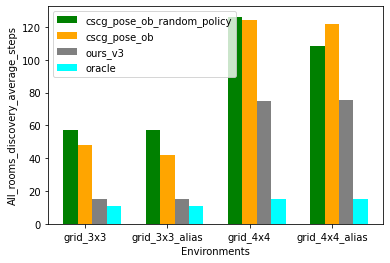

In [ ]:
#BAR PLOTS AVERAGE_STEPS
bar_plot(average_steps, envs, 'All_rooms_discovery_average_steps', 'Environments', model_names)

### Goal

/home/idlab332/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/idlab332/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[5.0, 2.5, nan, nan, 3.0, nan]


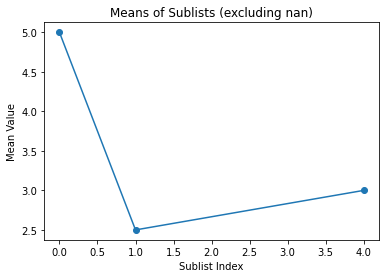

In [ ]:
average_steps_model = [[] for _ in range(6)]

# Append elements to each sublist
average_steps_model[0].append(5)
average_steps_model[1].append(2)
average_steps_model[1].append(3)
average_steps_model[4].append(3)

# Convert each sublist to a numpy array before calculating mean
means = [np.mean(np.array(sublist)) for sublist in average_steps_model]
print(means)
# Filter out nan values and corresponding indices
filtered_means = [mean for mean in means if not np.isnan(mean)]
indices = [i for i, mean in enumerate(means) if not np.isnan(mean)]

# Plot the non-nan values
plt.plot(indices, filtered_means, marker='o')
plt.xlabel('Sublist Index')
plt.ylabel('Mean Value')
plt.title('Means of Sublists (excluding nan)')
plt.show()

In [10]:
from envs.modules import get_l2_distance, astar

def get_short_term_goal(env, input=None):
    if input is None:
        start_pose = env.curr_loc
    elif isinstance(input, dict):
        start_pose = input['pose_pred']
    else:
        raise ValueError('get_short_term_goal:Input type not recognised ' + str(type(input)))

    output = [0,0,0]
    goal_poses_row, goal_poses_col = env.get_goal_position(env.goal_ob)
    all_relative_dists = []
    for r, c in zip(goal_poses_row,goal_poses_col):
        relative_dist = get_l2_distance(r, start_pose[0], c, start_pose[1])
        all_relative_dists.append(relative_dist)
    if len(all_relative_dists) == 0:
        #Goal not in env
        return None
    closest_goal_idx = np.argmin(all_relative_dists)
    
    goal_row = goal_poses_row[closest_goal_idx]
    goal_col = goal_poses_col[closest_goal_idx]
    print('start_pose', start_pose,'(goal_row, goal_col)', (goal_row, goal_col))
    path = astar(env.rooms, start_pose, (goal_row, goal_col))
    print('path', path)
    if path == None:
        return None
    output[0] = int((0%360.)/5.) #angle
    output[1] = len(path) -1 #step dist
    output[2] = path #gt path #NB: might not be the unique best path
    return output

In [74]:
#GET AVERAGE STEPS REACHING GOAL BY GOAL DIST TO START
from envs.minigrid import GridWorldEnv
import warnings
warnings.filterwarnings('ignore')
envs = ['grid_3x3', 'grid_3x3_alias', 'grid_4x4', 'grid_4x4_alias']#
model_names = ['ours_v3_wt_prior']#, 'ours_v3', 'ours_v3_wt_prior', 'cscg_pose_ob_random_policy', 'cscg_pose_ob']
nav_type = 'goal'

possible_actions = {'LEFT':0, 'RIGHT':1, 'UP':2, 'DOWN':3, 'STAY':4}
average_steps = [[0]*(len(envs)) for _ in range(len(model_names))]
oracle_a_steps = [[0]*(len(envs)) for _ in range(len(model_names))]

for id_m, model_name in enumerate(model_names):
    if 'wt_prior' in model_name:
        load_model = True
        model_name = 'ours_v3'
    else:
        load_model = False
    for id_e, env in enumerate(envs):
        a_failure = 0
        i = 0
        average_steps_model = [[] for _ in range(7)]
        oracle_a_steps_model = [[] for _ in range(7)]
        # Set the path to the folder containing the excel files
        if 'ours' in model_name:
            who = 'ours'
        else:
            who = 'cscg'
        folder_path = 'results/'+ env +'/' + who+'_'+ nav_type
        df_list, filepath_list = retrieve_df_data_from_folder_path(folder_path,model_name, nav_type, load_model =load_model)
        print('model', model_name, 'env', env,'number of tests:', len(df_list))
        for df, filepath in zip(df_list, filepath_list):
            i+=1
            # print(df['goal'][0])
            env_setup = GridWorldEnv(env, possible_actions, goal=df['goal'][0])
            _,_ = env_setup.reset(eval(df['poses'][0]))
            output = env_setup.get_short_term_goal()
            if output == None: #Goal does not exist in env
                continue
            headers = list(df.columns.values)
            stop_condition_header = [s for s in headers if 'stop_condition_' in s][0]
            
            if df[stop_condition_header][0] == True or df[stop_condition_header][0]>0:
                print(df['poses'][0], output[1], output[2], len(df['steps'])-2)
                #test = get_short_term_goal(env_setup)
                # if output[1] == 0:
                #     print(i,'n_steps', len(df['steps'])-2, 'oracle_steps', output[1])
                if ( len(df['steps'])-2 - output[1]) >2:
                    print(filepath)
                average_steps_model[output[1]].append(len(df['steps'])-2) #-2 because we remove the 'STAY' action
                oracle_a_steps_model[output[1]].append(output[1])
            else:
                a_failure+=1

                print('failure ', i)
        print('there is ', a_failure, ' failures in this model/env goal reaching')
        means = [np.mean(np.array(sublist)) for sublist in average_steps_model]
        average_steps[id_m][id_e] = means
        means = [np.mean(np.array(sublist)) for sublist in oracle_a_steps_model]
        oracle_a_steps[id_m][id_e] = means
        #print('model', model_name,id_m, 'env', env, np.mean(average_steps_model))
        #THIS ASSUMES WE HAVE SQUARED ENVS
#         dim_env = [substring for substring in env.split('_') if 'x' in substring][0]
#         average_steps[-1][id_e] =  int(dim_env[-1]) * 4 -1
# model_names.append('oracle')
print('model[env[n_steps]]')        
print(average_steps)
print(oracle_a_steps)

oracle_a_steps = np.nanmean(np.array(oracle_a_steps), axis=1)
average_steps = np.nanmean(np.array(average_steps), axis=1)

print('model[n_steps]')     
print(average_steps)
print(oracle_a_steps)
# oracle_a_steps[0][0] = 5.0
# print(oracle_a_steps)

model ours_v3 env grid_3x3 number of tests: 16
(0, 0) 2 [(0, 0), (0, 1), (1, 1)] 2
(0, 1) 2 [(0, 1), (0, 2), (1, 2)] 2
(1, 2) 2 [(1, 2), (1, 1), (1, 0)] 2
(0, 1) 3 [(0, 1), (0, 2), (1, 2), (2, 2)] 3
(0, 0) 1 [(0, 0), (1, 0)] 1
(0, 0) 3 [(0, 0), (0, 1), (0, 2), (1, 2)] 3
(1, 2) 1 [(1, 2), (2, 2)] 1
(1, 1) 0 [(1, 1)] 0
(0, 0) 3 [(0, 0), (0, 1), (0, 2), (1, 2)] 3
(1, 2) 1 [(1, 2), (1, 1)] 1
(1, 1) 0 [(1, 1)] 0
(0, 0) 4 [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)] 4
(0, 0) 4 [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)] 4
(0, 1) 2 [(0, 1), (0, 0), (1, 0)] 2
(1, 2) 0 [(1, 2)] 0
(0, 1) 1 [(0, 1), (1, 1)] 1
there is  0  failures in this model/env goal reaching
model[env[n_steps]]
[[[0.0, 1.0, 2.0, 3.0, 4.0, nan, nan]]]
[[[0.0, 1.0, 2.0, 3.0, 4.0, nan, nan]]]
model[n_steps]
[[ 0.  1.  2.  3.  4. nan nan]]
[[ 0.  1.  2.  3.  4. nan nan]]


In [59]:
array_data = np.array(oracle_a_steps)
array_data[0][0][2] = 2.0
array_data[0][1][2] = 1.0
print(array_data)
# Calculate the mean along the specified axis (axis=2 for sub-sub lists)
mean_values = np.nanmean(array_data, axis=1)
mean_values

[[[ 0.  1.  2. nan nan nan nan]
  [ 0.  1.  1. nan nan nan nan]]]


array([[0. , 1. , 1.5, nan, nan, nan, nan]])